In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

rawData = pd.read_csv('/content/drive/MyDrive/data/data.csv')

#data preprocessing 
#removing column 1 and 2(making InfoData)
rawData1_=rawData.iloc[:3616,:]
rawData2_=rawData.iloc[3617:,:]

rawData=pd.concat([rawData1_, rawData2_], ignore_index=True)

infoData = pd.DataFrame()


In [ ]:
rawData.shape


(42371, 1036)

In [ ]:
infoData['FLAG'] = rawData['FLAG']
infoData['CONS_NO'] = rawData['CONS_NO']
data = rawData.drop(['FLAG', 'CONS_NO'], axis=1)   #axis 1 column ,axis 0 row

# print(infoData)

#droping duplicate row
dropIndex = data[data.duplicated()].index  # duplicates drop
data = data.drop(dropIndex, axis=0)   #droping duplicate value present wen two row are same
infoData = infoData.drop(dropIndex, axis=0) #droping duplicate index infodata

#removing row with all zero(Nan) value
zeroIndex = data[(data.sum(axis=1) == 0)].index  # zero rows drop
data = data.drop(zeroIndex, axis=0) 
infoData = infoData.drop(zeroIndex, axis=0)  

#change column name to dates(2014/1/1 to 2014-01-01)
data.columns = pd.to_datetime(data.columns)  #columns reindexing according to dates

#sort data accoding to date( as previusoly column are unsorted)
data = data.reindex(sorted(data.columns), axis=1)
cols = data.columns

# reindex row name (as some row has been remove till this step due to duplicate or all nan values)
data.reset_index(inplace=True, drop=True)  # index sorting
infoData.reset_index(inplace=True, drop=True)

#filling nan value using neighbouring value (middle missing value replace by average 
#and other by maximum 2 distance element)
data = data.interpolate(method='linear', limit=7, limit_direction='both', axis=0).fillna(0) 


#removing erronoues value(fixing outliers)
for i in range(data.shape[0]):  # outliers treatment
    m = data.loc[i].mean()
    st = data.loc[i].std()
    data.loc[i] = data.loc[i].mask(data.loc[i] > (m + 2 * st), other=m + 2 * st)

# save preprocessed data without scaling
data.to_csv(r'visualization.csv', index=False, header=True)  # preprocessed data without scaling

#noramalisation process
scale = MinMaxScaler()
scaled = scale.fit_transform(data.values.T).T
mData = pd.DataFrame(data=scaled, columns=data.columns)
preprData = pd.concat([infoData, mData], axis=1, sort=False)  # Back to initial format
print("Noramalised data")
print(preprData)

# save preprocessed data after scaling
preprData.to_csv(r'preprocessedR.csv', index=False, header=True)

Noramalised data
       FLAG                           CONS_NO  2014-01-01 00:00:00  \
0         1  0387DD8A07E07FDA6271170F86AD9151             0.110118   
1         1  4B75AC4F2D8434CFF62DB64D0BB43103             0.140053   
2         1  B32AC8CC6D5D805AC053557AB05F5343             0.102224   
3         1  EDFC78B07BA2908B3395C4EB2304665E             0.144182   
4         1  6BCFD78138BC72A9BA1BFB0B79382192             0.178706   
...     ...                               ...                  ...   
40250     0  F1472871E1AFF49D4289564B6377D76C             0.410818   
40251     0  F3C8BBCD2DC26C1E0249DEEF6A4256B7             0.332902   
40252     0  A9A0FE83467A680FBFB0DBFC910DF227             0.107701   
40253     0  D9A6ADA018FA46A55D5438370456AA45             0.527563   
40254     0  F3406636BAD1E6E0826E8EDDC9A1BF00             0.570594   

       2014-01-02 00:00:00  2014-01-03 00:00:00  2014-01-04 00:00:00  \
0                 0.214161             0.265422             0.126066  

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix, \
    precision_recall_fscore_support, roc_auc_score
from keras import Sequential

# import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LeakyReLU,PReLU,ELU
# from keras.layers import Dropout

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.layers import Dense, Conv1D, Flatten, Conv2D
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import numpy as np
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

tf.random.set_seed(1234)
epochs_number = 1  # number of epochs for the neural networks
test_set_size = 0.2  # percentage of the test size comparing to the whole dataset
oversampling_flag = 0  # set to 1 to over-sample the minority class
oversampling_percentage = 0.2  # percentage of the minority class after the oversampling comparing to majority class


# Definition of functions
def read_data():
    rawData = pd.read_csv('preprocessedR.csv')

    # Setting the target and dropping the unnecessary columns
    y = rawData[['FLAG']]
    X = rawData.drop(['FLAG', 'CONS_NO'], axis=1)
    
    print('Normal Consumers:                    ', y[y['FLAG'] == 0].count()[0])
    print('Consumers with Fraud:                ', y[y['FLAG'] == 1].count()[0])
    print('Total Consumers:                     ', y.shape[0])
    print("Classification assuming no fraud:     %.2f" % (y[y['FLAG'] == 0].count()[0] / y.shape[0] * 100), "%")

    # columns reindexing according to dates
    X.columns = pd.to_datetime(X.columns)
    X = X.reindex(X.columns, axis=1)

    # Splitting the dataset into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y['FLAG'], test_size=test_set_size, random_state=0)
    print("Test set assuming no fraud:           %.2f" % (y_test[y_test == 0].count() / y_test.shape[0] * 100), "%\n")

    # Oversampling of minority class to encounter the imbalanced learning
    if oversampling_flag == 1:
        over = SMOTE(sampling_strategy=oversampling_percentage, random_state=0)
        X_train, y_train = over.fit_resample(X_train, y_train)
        print("Oversampling statistics in training set: ")
        print('Normal Consumers:                    ', y_train[y_train == 0].count())
        print('Consumers with Fraud:                ', y_train[y_train == 1].count())
        print("Total Consumers                      ", X_train.shape[0])

    return X_train, X_test, y_train, y_test


def results(y_test, prediction):
    print("Accuracy", 100 * accuracy_score(y_test, prediction))
    # print("RMSE:", mean_squared_error(y_test, prediction, squared=False))
    # print("MAE:", mean_absolute_error(y_test, prediction))
    # print("F1:", 100 * precision_recall_fscore_support(y_test, prediction)[2])
    print("AUC:", 100 * roc_auc_score(y_test, prediction))
    # print(confusion_matrix(y_test, prediction), "\n")


def ANN(X_train, X_test, y_train, y_test):
    print('Artificial Neural Network:')
    # for i in range(4,100,3):
    #     print("Epoch:",i)

    # Model creation
    model = Sequential()
    model.add(Dense(1000, input_dim=1034, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

    # model.fit(X_train, y_train, validation_split=0, epochs=i, shuffle=True, verbose=0)
    model.fit(X_train, y_train, validation_split=0, epochs=epochs_number, shuffle=True, verbose=1)
    prediction = model.predict(X_test)
    prediction = (prediction>0.5) #for convertion of pridected value into true(1) or false(0)
    model.summary()
    results(y_test, prediction)


def CNN1D(X_train, X_test, y_train, y_test):
    print('1D - Convolutional Neural Network:')

    # Transforming the dataset into tensors
    X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)
    X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

    # Model creation
    model = Sequential()
    model.add(Conv1D(100, kernel_size=2, input_shape=(1034, 1), activation='relu'))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss=keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])

    # model.fit(X_train, y_train, epochs=1, validation_split=0.1, shuffle=False, verbose=1)
    model.fit(X_train, y_train, epochs=epochs_number, validation_split=0, shuffle=False, verbose=1)
    # prediction = model.predict_classes(X_test)
    prediction = model.predict(X_test)
    prediction = (prediction>0.5)
    model.summary()
    results(y_test, prediction)




def LR(X_train, X_test, y_train, y_test):
    print('Logistic Regression:')
    '''
    # Parameters selection 
    param_grid = {'C': [0.1,1,10,100],'solver': ['newton-cg', 'lbfgs']}
    grid = GridSearchCV(LogisticRegression(max_iter=1000,random_state=0), param_grid=param_grid, n_jobs=-1)
    grid.fit(X_train, y_train)
    df = pd.DataFrame(grid.cv_results_)
    print(df[['param_C', 'param_solver', 'mean_test_score', 'rank_test_score']])
    '''
    model = LogisticRegression(C=1000, max_iter=1000, n_jobs=-1, solver='newton-cg')
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    results(y_test, prediction)


def DT(X_train, X_test, y_train, y_test):
    print('Decision Tree:')
    model = DecisionTreeClassifier(random_state=0)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    results(y_test, prediction)


def RF(X_train, X_test, y_train, y_test):
    print('Random Forest:')
    '''
    # Parameters selection 
    param_grid = {'n_estimators':[10,100,1000]}
    grid = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=param_grid, n_jobs=-1)
    grid.fit(X_train, y_train)
    df = pd.DataFrame(grid.cv_results_)
    print(df[['param_criterion', 'mean_test_score', 'rank_test_score']])
    '''

    model = RandomForestClassifier(n_estimators=100, min_samples_leaf=1, max_features='auto',  # max_depth=10,
                                   random_state=0, n_jobs=-1)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    results(y_test, prediction)


def SVM(X_train, X_test, y_train, y_test):
    model = SVC(random_state=0)
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    results(y_test, prediction)


# ----Main----
X_train, X_test, y_train, y_test = read_data()

# Uncomment any model to test
# ANN(X_train, X_test, y_train, y_test)
# CNN1D(X_train, X_test, y_train, y_test)
# RF(X_train, X_test, y_train, y_test)
# LR(X_train, X_test, y_train, y_test)
# DT(X_train, X_test, y_train, y_test)
SVM(X_train, X_test, y_train, y_test)

Normal Consumers:                     36676
Consumers with Fraud:                 3579
Total Consumers:                      40255
Classification assuming no fraud:     91.11 %
Test set assuming no fraud:           90.81 %



/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp']. An error will be raised in 1.2.
  FutureWarning,


Accuracy 91.16879890696808
AUC: 52.020188017315625


In [ ]:
def Combined(X_train, X_test, y_train, y_test):
  print('2D - Convolution Neural Network:')
  # Transforming every row of the train set into a 2D array and then into a tensor
  n_array_X_train = X_train.to_numpy()
  n_array_X_train_extended = np.hstack((n_array_X_train, np.zeros((n_array_X_train.shape[0],2)))) # adding two empty columns in order to make the number of columns 
  # an exact multiple of 7
  week = []
  for i in range(n_array_X_train_extended.shape[0]):
    a = np.reshape(n_array_X_train_extended[i], (-1, 7, 1))
    week.append(a)
  X_train_reshaped = np.array(week)
  # Transforming every row of the train set into a 2D array and then into a tensor
  n_array_X_test = X_test.to_numpy() #X_test to 2D - array
  n_array_X_train_extended = np.hstack((n_array_X_test, np.zeros((n_array_X_test.shape[0], 2))))
  week2 = []
  for i in range(n_array_X_train_extended.shape[0]):
    b=np.reshape(n_array_X_train_extended[i], (-1, 7, 1))
    week2.append(b)
  X_test_reshaped = np.array(week2)
  input_shape = (1, 148, 7, 1) #input shape of the tensor# Model creation
  model1 = Sequential()
  model1.add(Conv2D(kernel_size = (7, 3), filters =32,input_shape=input_shape[1:], activation= 'relu', data_format='channels_last'))
  model1.add(Flatten())
  model1.add(Dense(100, activation='relu'))
  model1.add(Dense(100, activation='relu'))
  model1.add(Dense(64, activation='relu'))
  model1.add(Dense(1, activation='relu'))
  model1.compile(loss=keras.losses.binary_crossentropy,optimizer='adam' ,metrics = ['accuracy'])
  model1.fit(X_train_reshaped, y_train, validation_split=0.1, epochs=epochs_number, shuffle=False, verbose=1)
  prediction1 = model1.predict(X_test_reshaped)
  # prediction1 = (prediction1>0.5)
  print(prediction1)
  print('1D - convolution Neural Network:')
  # Transforming the dataset into tensors
  X_train = X_train.to_numpy().reshape(X_train.shape[0],X_train.shape[1], 1)
  X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)
  #Model creation
  model2 = Sequential()
  model2.add(Conv1D(100, kernel_size = 7, input_shape=(1034, 1), activation= 'relu'))
  model2.add(Flatten())
  model2.add(Dense(100, activation='relu'))
  model2.add(Dense(100, activation='relu'))
  model2.add(Dense(64, activation='relu'))
  model2.add(Dense(1, activation='sigmoid'))
  model2.compile(loss=keras.losses.binary_crossentropy,optimizer='adam' ,metrics = ['accuracy'])
  model2.fit(X_train, y_train, validation_split=0,epochs=epochs_number, shuffle=False, verbose=1)
  prediction2 = model2.predict(X_test)
  # prediction2 = (prediction2>0.5) 
  return prediction1 ,prediction2


def deep_and_wideCNN(prediction1, prediction2):
  n= len(prediction2)
  for i in range(n) :
    if(prediction1[i]!=prediction2[i]):
      prediction1[i]=0
  # prediction1 = (prediction1>0)
  results(y_test , prediction1)

# prediction1, prediction2 =Combined(X_train, X_test, y_train, y_test)
# deep_and_wideCNN(prediction1 , prediction2) 

Text(0, 0.5, 'Consumption')

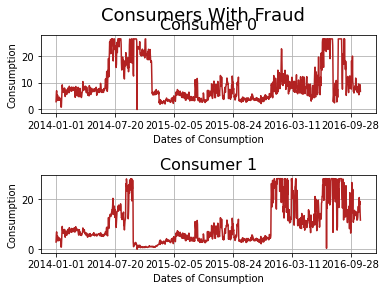

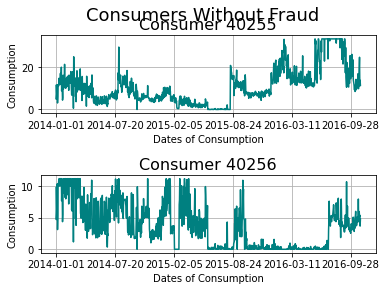

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

rawData1 = pd.read_csv('visualization.csv', nrows=3) #taking first 3 rows
cols = rawData1.columns
rawData2 = pd.read_csv('visualization.csv', skiprows=187) #removing first 189 rows
rawData2.columns = cols
data = pd.concat([rawData1, rawData2], ignore_index=True) #ignore_index=True to make row index number 
                                            #continuous((0,1)+(0,1) ->form(0,1,0,1) to->(0,1,2,3))

#plot 1D graph for consumer
fig, axs = plt.subplots(2, 1)
fig.suptitle('Consumers With Fraud', fontsize=18)
plt.subplots_adjust(hspace=0.8)


data.loc[0].plot(ax=axs[0], color='firebrick', grid=True)
axs[0].set_title('Consumer 0', fontsize=16)
axs[0].set_xlabel('Dates of Consumption')
axs[0].set_ylabel('Consumption')

data.loc[2].plot(ax=axs[1], color='firebrick', grid=True)
axs[1].set_title('Consumer 1', fontsize=16)
axs[1].set_xlabel('Dates of Consumption')
axs[1].set_ylabel('Consumption')

fig, axs = plt.subplots(2, 1)
fig.suptitle('Consumers Without Fraud', fontsize=18)
plt.subplots_adjust(hspace=0.8)

data.loc[3].plot(ax=axs[0], color='teal', grid=True)
axs[0].set_title('Consumer 40255', fontsize=16)
axs[0].set_xlabel('Dates of Consumption')
axs[0].set_ylabel('Consumption')

data.loc[4].plot(ax=axs[1], color='teal', grid=True)
axs[1].set_title('Consumer 40256', fontsize=16)
axs[1].set_xlabel('Dates of Consumption')
axs[1].set_ylabel('Consumption')



Text(0, 0.5, 'Values')

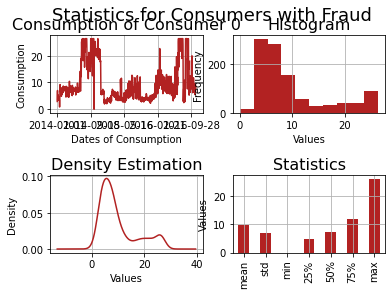

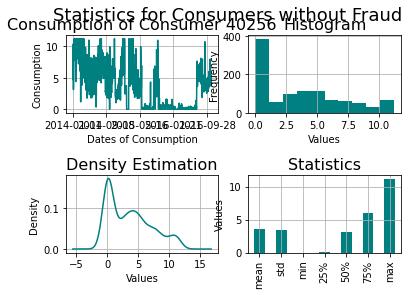

In [ ]:
#statistics for consumer 
#with fraud
fig2, axs2 = plt.subplots(2, 2)
fig2.suptitle('Statistics for Consumers with Fraud', fontsize=18)
plt.subplots_adjust(hspace=0.8)

data.loc[0].plot(ax=axs2[0, 0], color='firebrick', grid=True)
axs2[0, 0].set_title('Consumption of Consumer 0', fontsize=16)
axs2[0, 0].set_xlabel('Dates of Consumption')
axs2[0, 0].set_ylabel('Consumption')

data.loc[0].hist(color='firebrick', ax=axs2[0, 1], grid=True)
axs2[0, 1].set_title('Histogram', fontsize=16)
axs2[0, 1].set_xlabel('Values')
axs2[0, 1].set_ylabel('Frequency')

data.loc[0].plot.kde(color='firebrick', ax=axs2[1, 0], grid=True)
axs2[1, 0].set_title('Density Estimation', fontsize=16)
axs2[1, 0].set_xlabel('Values')
axs2[1, 0].set_ylabel('Density')

data.loc[0].describe().drop(['count']).plot(kind='bar', ax=axs2[1, 1], color='firebrick', grid=True)
axs2[1, 1].set_title('Statistics', fontsize=16)
axs2[1, 1].set_ylabel('Values')

#without fraud
fig3, axs3 = plt.subplots(2, 2)
fig3.suptitle('Statistics for Consumers without Fraud', fontsize=18)
plt.subplots_adjust(hspace=0.8)
data.loc[4].plot(ax=axs3[0, 0], color='teal', grid=True)
axs3[0, 0].set_title('Consumption of Consumer 40256', fontsize=16)
axs3[0, 0].set_xlabel('Dates of Consumption')
axs3[0, 0].set_ylabel('Consumption')

data.loc[4].hist(color='teal', ax=axs3[0, 1])
axs3[0, 1].set_title('Histogram', fontsize=16)
axs3[0, 1].set_xlabel('Values')
axs3[0, 1].set_ylabel('Frequency')

data.loc[4].plot.kde(color='teal', ax=axs3[1, 0], grid=True)
axs3[1, 0].set_title('Density Estimation', fontsize=16)
axs3[1, 0].set_xlabel('Values')
axs3[1, 0].set_ylabel('Density')

data.loc[4].describe().drop(['count']).plot(kind='bar', ax=axs3[1, 1], color='teal', grid=True)
axs3[1, 1].set_title('Statistics', fontsize=16)
axs3[1, 1].set_ylabel('Values')

